# Экстраполяция временных рядов
### Многопараметрическая экстраполяция

Под множественными регрессионными моделями будем понимать класс моделей, в которых значения одного или множества исследуемых параметров зависят от нескольких (более одного) других параметров.

In [288]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [289]:
# Загрузим данные. В практической работе можно использовать эти данные или взять данные с открытых источников
data_path = "C:/Users/Анна/Desktop/ML занятия/HSE ML/HSE ML/DataSets"
# Стоимость и объем продаж акций компании Google (работа с временными рядами, может быть решена задача прогнозирования)
data1 = pd.read_csv(data_path + "/DataSet1_3.csv")
# статистика заболеваемости COVID-19 по странам (работа с временными рядами)
data2 = pd.read_csv(data_path + "/DataSet1_4.csv")
# данные о температуре и потребляемой мощности электрической энергии (раноотстоящие узлы).
data3 = pd.read_csv(data_path + "/DataSet3_1.csv")
# данные о стоимости доллара и нефти (не равноотстоящие узлы)
data4 = pd.read_csv(data_path + "/DataSet3_2.csv")

In [290]:
# Выберем данные
n1 = 101
n2 = 300
data = data1[n1:n2].copy()
data['Date'] = pd.to_datetime(data['Date'], format="%Y-%m-%d")
data['Seconds'] = ((data['Date'] - data['Date'].iloc[0]).dt.total_seconds() + 1)/(60*60*24)
data = data.rename(columns = {'Close':'y', 'Seconds':'x'})
data = data.drop(columns=['Date', 'High', 'Low', 'Volume'])
data['lag'] = data1['Close'].iloc[n1-1:n2].shift(1).copy()

In [291]:
data1['Close'].iloc[n1-1:n2-1]

100    190.87
101    186.16
102    186.10
103    191.50
104    189.91
        ...  
294    228.05
295    227.59
296    226.71
297    227.60
298    221.74
Name: Close, Length: 199, dtype: float64

Добавление значений целевого параметра со сдвигом на один шаг в прошлое при построении регрессии называется созданием лагов (lags) для целевой переменной. Это позволяет учесть зависимость текущего значения целевой переменной от ее предыдущих значений.

In [292]:
# уберем все не числовые признаки
num_data = data.dtypes[data.dtypes!='object'].index
data = data[num_data]
data

,Open,y,x,lag
101,189.33,186.16,0.000012,190.87
102,187.09,186.10,1.000012,186.16
103,186.96,191.50,2.000012,186.10
104,192.92,189.91,3.000012,191.50
105,188.28,187.41,6.000012,189.91
...,...,...,...,...
295,229.84,227.59,282.000012,228.05
296,229.23,226.71,283.000012,227.59
297,226.51,227.60,286.000012,226.71
298,225.28,221.74,287.000012,227.60


In [293]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['y'])
y = data['y']

X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

### Метод наименьших квадратов

Используем МНК для многопараметрической регрессии

In [294]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(np.array(X_train), np.array(y_train))
res_mnk = model.predict(np.array(x_test))

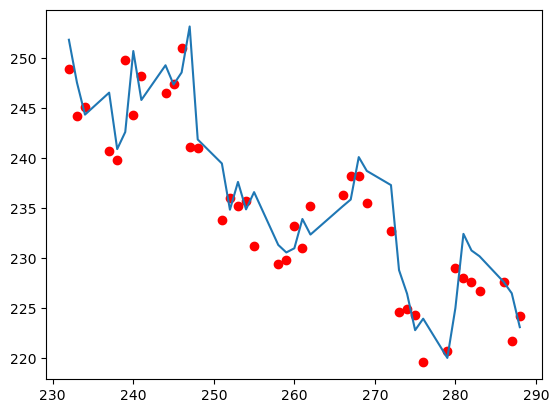

In [295]:
plt.plot(x_test['x'], res_mnk)
plt.scatter(x_test['x'], y_test, color='red')

### SVM

In [296]:
# X_train = X_train[['x','Open']]
# X_train

In [297]:
from sklearn.svm import SVR
# Создайте модель SVM для регрессии
model = SVR(kernel='linear', C=1.0)

# Обучите модель на тренировочных данных
res_svm = model.fit(X_train, y_train).predict(x_test)

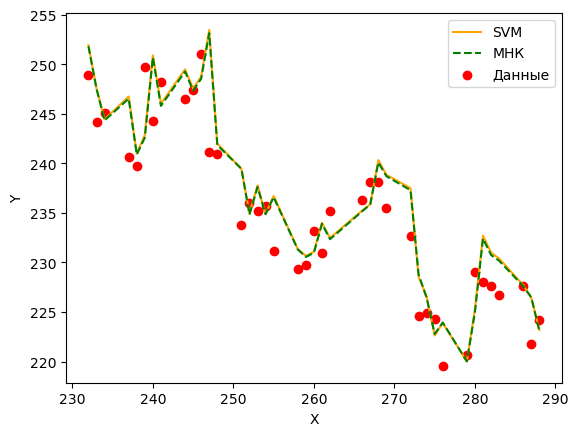

In [298]:
# Визуализация данных и регрессии
plt.plot(x_test['x'], res_svm, color='orange', label='SVM')
#для сравнения, добавим данные, полученные в предыдущем примере
plt.plot(x_test['x'], res_mnk, color='green',label='МНК', ls='dashed')
plt.scatter(x_test['x'], y_test, color='red', label='Данные')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

### kNN

In [299]:
#мы изменяли тестовую и тренировочную выборки, поэтому создадим их снова
from sklearn.model_selection import train_test_split

X = data.drop(columns=['y'])
y = data['y']

X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [300]:
from sklearn.neighbors import KNeighborsRegressor

# Создаем и обучаем модель k-NN
k = 5  # Количество соседей (замените на нужное значение)
model = KNeighborsRegressor(n_neighbors=k)
model.fit(X_train, y_train)

# Делаем прогноз
res_knn = model.predict(x_test)

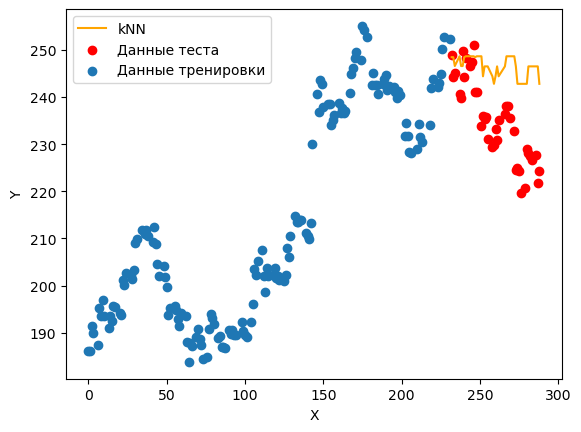

In [308]:
plt.plot(x_test['x'], res_knn, color='orange', label='kNN')
plt.scatter(x_test['x'], y_test, color='red', label='Данные теста')
plt.scatter(X_train['x'], y_train, label='Данные тренировки')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

### Lasso (Least absolute shrinkage and selection operator)

 Регрессия по методу наименьших квадратов (МНК) часто может стать неустойчивой, то есть сильно зависящей от обучающих данных, что обычно является проявлением тенденции к переобучению. Избежать такого переобучения помогает регуляризация - общий метод, заключающийся в наложении дополнительных ограничений на искомые параметры, которые могут предотвратить излишнюю сложность модели. Смысл процедуры заключается в “стягивании” в ходе настройки вектора коэффициентов  β  таким образом, чтобы они в среднем оказались несколько меньше по абсолютной величине, чем это было бы при оптимизации по МНК.

 Метод регрессии “лассо” (LASSO, Least Absolute Shrinkage and Selection Operator) заключается во введении дополнительного слагаемого регуляризации в функционал оптимизации модели, что часто позволяет получать более устойчивое решение. Условие минимизации квадратов ошибки при оценке параметров  $\hat{\beta}$
  выражается следующей формулой:

$\hat{\beta} = argmin(\sum_{i}^n(y_i-\sum_{j}^m \beta x_{ij})^2 + \lambda |\beta|)$,
где  λ  - параметр регуляризации, имеющий смысл штрафа за сложность.

λ = 0, метод ЛАССОВ сводится к МНК, а при увеличении $\lambda$ формируемая модель становится все более “лаконичной”, пока не превратится в нуль-модель.

Оптимальная $\lambda$ находится с использованием кросс-валидации (т.е. такая $\lambda$, которой соответствует наименьшая ошибка прогноза)


In [302]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['y'])
y = data['y']

X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

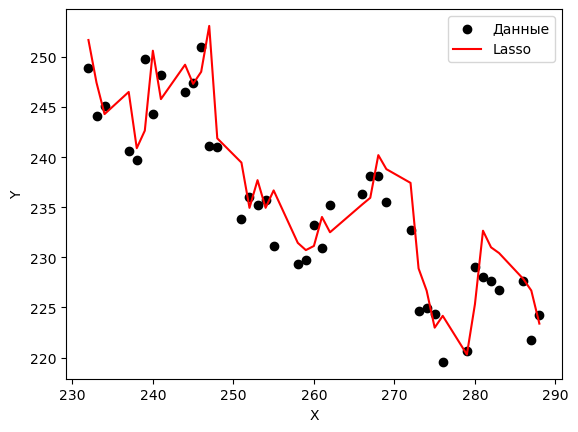

In [303]:
from sklearn.linear_model import Lasso
# Создаем и обучаем модель Lasso-регрессии
alpha = 2  # Параметр регуляризации (замените на желаемое значение)
model = Lasso(alpha=alpha)
model.fit(X_train, y_train)

# Делаем прогноз
res_lasso = model.predict(x_test)

# Графики
plt.scatter(x_test['x'], y_test, label='Данные', color="black")
plt.plot(x_test['x'], res_lasso, label='Lasso', color="red")
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

### Метод частных наименьших квадратов (PLS)

Основная цель PLS - это уменьшить размерность набора данных, проектируя исходные признаки на некоторое меньшее число новых признаков (компонентов), которые линейно связаны с зависимой переменной. Это помогает улучшить способность модели к предсказанию, особенно в случаях, когда исходный набор признаков мультиколлинеарен (сильно коррелируют между собой) или имеет много шумовых переменных.

Общая базовая модель многомерного PLS:

$X=TP^T+E$
$Y=UQ^T+F$

где $X$ - матрица предикторов $m*n$, $Y$ - матрица ответов $n*p$; $T$ и $U$ - это матрицы $n*l$, которые являются, соответственно, проекциями $X$ (оценка X, матрица компонентов или факторов) и проекциями Y (Y баллы); $P$ и $Q$,соответственно $m*l$ и $ p*l$ , и ортогональная загрузка. матрицы; а матрицы $E$ и $F$ - это члены ошибок, которые считаются независимыми и одинаково распределенными случайными нормальными величинами. Разложение $X$ и $Y$ производится таким образом, чтобы максимизировать ковариацию между $T$ и $U$.

(Источник https://wiki5.ru/wiki/Partial_least_squares_regression)



In [304]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['y'])
y = data['y']

X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [305]:
from sklearn.cross_decomposition import PLSRegression

# Создаем и обучаем модель PLS
n_components = 2  # Количество компонент PLS (замените на желаемое значение)
model = PLSRegression(n_components=n_components)
model.fit(X_train, y_train)

# Делаем прогноз
res_pls = model.predict(x_test)



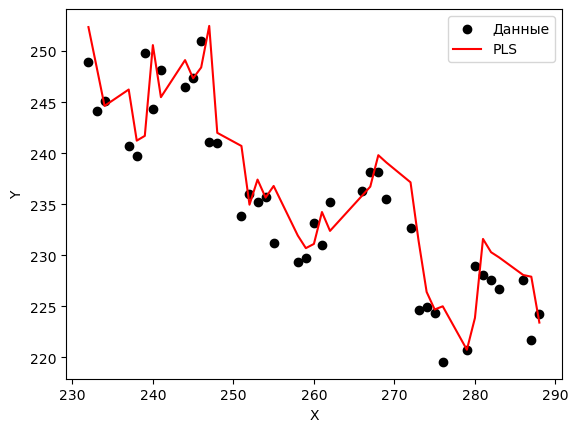

In [306]:
x_test['y'] = res_pls
x_test = x_test.sort_values(by='x')

# Графики
plt.scatter(x_test['x'], y_test, color="black", label='Данные')
plt.plot(x_test['x'], res_pls, color="red", label='PLS')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

Посмотрим итоговые результаты:

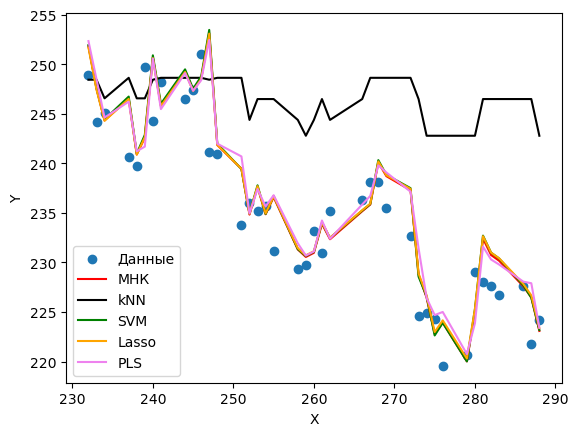

In [307]:
plt.scatter(x_test['x'], y_test, label='Данные')
plt.plot(x_test['x'], res_mnk, color="red", label='МНК')
plt.plot(x_test['x'], res_knn, color="black", label='kNN')
plt.plot(x_test['x'], res_svm, color="green", label='SVM')
plt.plot(x_test['x'], res_lasso, color="orange", label='Lasso')
plt.plot(x_test['x'], res_pls, color="violet", label='PLS')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()